## Predict Credit Consumption of Customer For Leading Bank  – Project Report
###  1. Business Problem
A leading bank wants to predict future credit card spending of its customers over the next 3 months (July, August, September). This will help:

Understand customer behavior, Regression problem

### 2. Data Availability
The bank provided three datasets:

CustomerDemographics.csv – Info like gender, age, income

CustomerBehaviorData.csv – Past credit/debit transactions, limits, loans, investments

CreditConsumptionData.csv – Credit card spend (April–June) and future target (cc_cons) for July–Sep

### 3. Steps Performed
Data Collection & Merging

Identifying Continuous and Categorical columns [account_type,gender,Income]

EDA using Profiling + Manual Exploration (total, cardinality, min, max, outlier)

Outlier & Missing Value Handling

Dummy ,correlation

Feature Selection

Train-Test Split (on rows with known cc_cons)

Model Building and Training

Model Evaluation using RMSPE

Prediction for records with missing cc_cons

### 4. Techniques Used
* EDA (Exploratory Data Analysis)

Univariate and bivariate analysis

Outlier detection and clipping

Missing value treatment

* Feature Engineering

Combined datasets on ID

Dropped irrelevant features like loan_enq

Identified numerical vs. categorical columns

Clipped outliers (5th–95th percentile)

Mean imputation for missing values

* Modeling

Regression models tried:

Linear Regression

Decision Tree Regressor

Random Forest Regressor (best performance)



### 5. Evaluation Metric
RMSPE (Root Mean Square Percentage Error)

Suitable when target values vary a lot

Penalizes larger percentage errors more

RMSPE 
### 6. Model Tuning
Tuned Random Forest using:

n_estimators (number of trees)

max_depth (tree depth)

min_samples_leaf, max_features

Used GridSearchCV tuning for best parameters.

### 7. Challenges Faced
Missing target (cc_cons) values: Had to split data accordingly

Outliers in financial data 

Imbalanced loan info (loan_enq mostly 'Y')

### 8. Outcome
Built a well-performing model (Random Forest) with low RMSPE

Predicted average credit consumption for missing users

Delivered clean predictions for future targeting

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from ydata_profiling import ProfileReport

* Importing Data

In [96]:
credit= pd.read_excel(r"C:\Data Science Files\11. Capstone Case Study - Predict Cred Card Consumption\CreditConsumptionData.xlsx")
behavior= pd.read_excel(r"C:\Data Science Files\11. Capstone Case Study - Predict Cred Card Consumption\CustomerBehaviorData.xlsx")
demo= pd.read_excel(r"C:\Data Science Files\11. Capstone Case Study - Predict Cred Card Consumption\CustomerDemographics.xlsx")

* Merging the Data

In [97]:
credit_behav = pd.merge(left= credit, right = behavior, on = 'ID', how = "inner")

In [98]:
data = pd.merge(left= credit_behav, right = demo, on = 'ID', how= 'inner')

* Data Overview

In [99]:
data.head(2)

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,emi_active,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
0,17051,16239.0,2017.46,29066.66,15919.84,2197.00,3752.00,29798.00,1.0,4,...,3448.84,current,M,30,MEDIUM,26.4,9,9,355,0
1,11491,39002.0,7687.00,1308.00,41888.92,2216.92,7060.53,3143.36,2.0,27,...,3812.69,current,M,37,LOW,14.4,7,7,485,0


In [100]:
data.describe()

,ID,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction
count,20000.000000,15000.000000,20000.000000,20000.000000,1.999900e+04,19999.000000,20000.000000,19999.000000,19999.000000,20000.000000,...,20000.000000,20000.000000,2.000000e+04,1.999900e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,9999.500000,9369.030957,17856.990922,8130.453413,1.618836e+04,7702.123897,12135.806021,7109.708341,41.611631,33.569100,...,19.905450,44.529100,5.284985e+04,1.539887e+04,47.672300,15.217250,5.496050,5.496050,598.929400,0.718000
std,5773.647028,7552.997163,25158.878234,14572.188829,2.651068e+04,17893.127746,18790.984789,13313.935609,97.835475,50.316925,...,27.055323,35.080453,1.343175e+05,1.202541e+05,30.359771,20.481455,2.870452,2.870452,220.140472,0.449985
min,0.000000,610.099000,253.000000,19.350000,1.570000e+02,22.000000,65.000000,62.000000,1.000000,1.000000,...,1.000000,0.000000,6.000000e-02,0.000000e+00,25.000000,0.500000,1.000000,1.000000,0.000000,0.000000
25%,4999.750000,4808.621700,4377.000000,1624.650000,3.635910e+03,1634.260000,2999.075000,1361.100000,5.000000,8.000000,...,4.000000,12.000000,1.896450e+04,1.545940e+03,33.000000,5.100000,3.000000,3.000000,424.000000,0.000000
50%,9999.500000,7408.604400,10214.642500,3964.750000,8.635230e+03,3791.720000,6656.800000,3326.000000,10.000000,23.000000,...,7.000000,37.000000,3.025000e+04,3.934660e+03,40.000000,9.900000,6.000000,6.000000,623.000000,1.000000
75%,14999.250000,11518.832800,21189.000000,9339.020000,1.865531e+04,8263.590000,14195.727500,7458.820000,44.000000,43.000000,...,21.000000,73.000000,5.344900e+04,9.376390e+03,53.000000,18.000000,8.000000,8.000000,799.000000,1.000000
max,19999.000000,160735.934800,441031.330000,229255.000000,1.117246e+06,911223.490000,382914.100000,233384.000000,531.000000,601.000000,...,117.000000,133.000000,5.200000e+06,7.447125e+06,223.000000,203.000000,10.000000,10.000000,974.000000,1.000000


In [101]:
data.columns

Index(['ID', 'cc_cons', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may',
       'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr',
       'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may',
       'dc_count_jun', 'card_lim', 'personal_loan_active',
       'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'loan_enq', 'emi_active', 'account_type', 'gender', 'age', 'Income',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code',
       'NetBanking_Flag', 'Avg_days_between_transaction'],
      dtype='object')

In [102]:
data.loan_enq.value_counts()

loan_enq
Y    19998
Name: count, dtype: int64

In [103]:
data.drop(columns="loan_enq",inplace= True)

In [104]:
data.columns

Index(['ID', 'cc_cons', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may',
       'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr',
       'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may',
       'dc_count_jun', 'card_lim', 'personal_loan_active',
       'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'emi_active', 'account_type', 'gender', 'age', 'Income',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code',
       'NetBanking_Flag', 'Avg_days_between_transaction'],
      dtype='object')

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   cc_cons                       15000 non-null  float64
 2   cc_cons_apr                   20000 non-null  float64
 3   dc_cons_apr                   20000 non-null  float64
 4   cc_cons_may                   19999 non-null  float64
 5   dc_cons_may                   19999 non-null  float64
 6   cc_cons_jun                   20000 non-null  float64
 7   dc_cons_jun                   19999 non-null  float64
 8   cc_count_apr                  19999 non-null  float64
 9   cc_count_may                  20000 non-null  int64  
 10  cc_count_jun                  20000 non-null  int64  
 11  dc_count_apr                  20000 non-null  int64  
 12  dc_count_may                  20000 non-null  int64  
 13  d

In [106]:
data.dtypes

ID                                int64
cc_cons                         float64
cc_cons_apr                     float64
dc_cons_apr                     float64
cc_cons_may                     float64
dc_cons_may                     float64
cc_cons_jun                     float64
dc_cons_jun                     float64
cc_count_apr                    float64
cc_count_may                      int64
cc_count_jun                      int64
dc_count_apr                      int64
dc_count_may                      int64
dc_count_jun                      int64
card_lim                          int64
personal_loan_active              int64
vehicle_loan_active               int64
personal_loan_closed            float64
vehicle_loan_closed               int64
investment_1                    float64
investment_2                    float64
investment_3                    float64
investment_4                    float64
debit_amount_apr                float64
credit_amount_apr               float64


In [107]:
data.select_dtypes(exclude = 'object').columns

Index(['ID', 'cc_cons', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may',
       'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr',
       'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may',
       'dc_count_jun', 'card_lim', 'personal_loan_active',
       'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'emi_active', 'age', 'Emp_Tenure_Years', 'Tenure_with_Bank',
       'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction'],
      dtype='object')

### EDA

In [108]:
ProfileReport(data,dark_mode=True, explorative= True, minimal =True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [109]:
data.select_dtypes(include='object').columns

Index(['account_type', 'gender', 'Income'], dtype='object')

In [110]:
continuous = [ 'cc_cons', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may',
       'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr',
       'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may',
       'dc_count_jun', 'card_lim', 'personal_loan_active',
       'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'emi_active', 'age', 'Emp_Tenure_Years', 'Tenure_with_Bank',
       'Avg_days_between_transaction','region_code', 'NetBanking_Flag']
categorical = ['account_type', 'gender', 'Income']

In [111]:
numeric_data = data.loc[:,continuous]

In [112]:
cat_data = data.loc[:,categorical]

In [113]:
def summary (x):
    x_total = x.shape[0]
    x_miss = x.isna().sum()
    x_miss_per = (x_miss/x_total*100)

    q1 = x.quantile(0.25)
    q2 = x.quantile(0.75)
    iqr = q2-q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q2 + 1.5 * iqr

    return pd.Series([ x.dtype,x.nunique(),x.sum(),x_total,x_miss,x.mean(),x.min(),x.quantile(0.01),x.quantile(0.05),x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75),x.quantile(0.90),x.quantile(0.95),x.quantile(0.99),x.max()],
                        
                    index=['dtype','cardinality','sum','total','missing', 'mean','min', ' p1','p5','p10','p25','p50','p75','p90','p95','p99','max'])

In [114]:
numeric_data.apply(summary)

,cc_cons,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,...,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,region_code,NetBanking_Flag
dtype,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,...,int64,int64,float64,float64,int64,float64,int64,int64,int64,int64
cardinality,14998,8459,3861,8504,4053,7347,3019,50,58,67,...,39,66,5833,5940,43,270,10,2,10,211
sum,140535464.3485,357139818.44,162609068.27,323751105.97,154034775.82,242716120.41,142187057.12,832191.0,671382,829404,...,398109,890582,1056996951.42,307961976.6,953446,304345.0,109921,14360,109921,11978588
total,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
missing,5000,0,0,1,1,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
mean,9369.030957,17856.990922,8130.453413,16188.364717,7702.123897,12135.806021,7109.708341,41.611631,33.5691,41.4702,...,19.90545,44.5291,52849.847571,15398.868773,47.6723,15.21725,5.49605,0.718,5.49605,598.9294
min,610.099,253.0,19.35,157.0,22.0,65.0,62.0,1.0,1,1,...,1,0,0.06,0.0,25,0.5,1,0,1,0
p1,1684.08119,641.9886,153.1286,509.49,152.1,334.0,190.95,1.0,1.0,1.0,...,1.0,0.0,160.0,26.739,27.0,0.9,1.0,0.0,1.0,233.0
p5,2584.08145,1219.0,378.0,1035.774,410.94,825.101,390.0,1.0,2.0,3.0,...,2.0,2.0,1679.5,197.95,28.0,1.7,1.0,0.0,1.0,249.0
p10,3237.77268,1908.0,643.85,1666.328,731.0,1367.52,607.0,2.0,3.0,4.0,...,2.0,7.0,11200.0,461.06,29.0,2.7,2.0,0.0,2.0,269.0


In [115]:
numeric_data.apply(lambda x : x.clip(lower = x.quantile(0.05),upper = x.quantile(0.95), inplace=True))

cc_cons                         None
cc_cons_apr                     None
dc_cons_apr                     None
cc_cons_may                     None
dc_cons_may                     None
cc_cons_jun                     None
dc_cons_jun                     None
cc_count_apr                    None
cc_count_may                    None
cc_count_jun                    None
dc_count_apr                    None
dc_count_may                    None
dc_count_jun                    None
card_lim                        None
personal_loan_active            None
vehicle_loan_active             None
personal_loan_closed            None
vehicle_loan_closed             None
investment_1                    None
investment_2                    None
investment_3                    None
investment_4                    None
debit_amount_apr                None
credit_amount_apr               None
debit_count_apr                 None
credit_count_apr                None
max_credit_amount_apr           None
d

In [116]:
numeric_data.isnull().sum()

cc_cons                         5000
cc_cons_apr                        0
dc_cons_apr                        0
cc_cons_may                        1
dc_cons_may                        1
cc_cons_jun                        0
dc_cons_jun                        1
cc_count_apr                       1
cc_count_may                       0
cc_count_jun                       0
dc_count_apr                       0
dc_count_may                       0
dc_count_jun                       0
card_lim                           0
personal_loan_active               0
vehicle_loan_active                0
personal_loan_closed               1
vehicle_loan_closed                0
investment_1                       0
investment_2                       0
investment_3                       2
investment_4                       0
debit_amount_apr                   0
credit_amount_apr                  0
debit_count_apr                    1
credit_count_apr                   0
max_credit_amount_apr              0
d

In [117]:
numeric_data.columns

Index(['cc_cons', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'personal_loan_active', 'vehicle_loan_active',
       'personal_loan_closed', 'vehicle_loan_closed', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr',
       'credit_amount_apr', 'debit_count_apr', 'credit_count_apr',
       'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may',
       'credit_count_may', 'debit_count_may', 'max_credit_amount_may',
       'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun',
       'debit_count_jun', 'max_credit_amount_jun', 'emi_active', 'age',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'Avg_days_between_transaction',
       'region_code', 'NetBanking_Flag'],
      dtype='object')

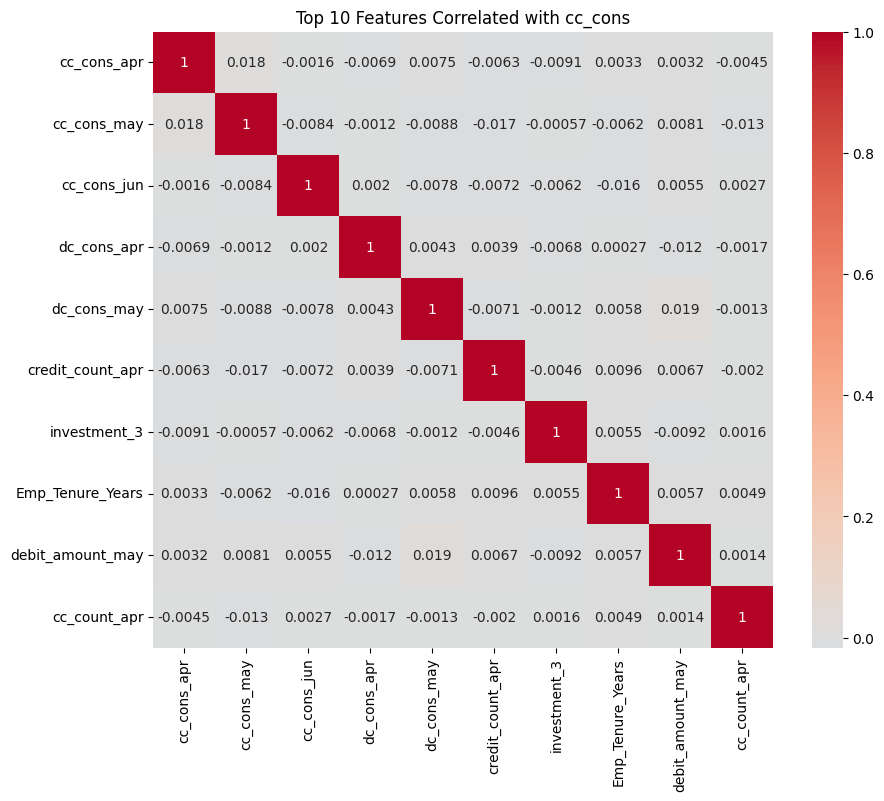

In [213]:
top_corr = numeric_data.corr()['cc_cons'].drop('cc_cons').abs().sort_values(ascending=False).head(10).index


plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data[top_corr].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Top 10 Features Correlated with cc_cons")
plt.show()


In [118]:
num_1 = numeric_data[['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr',
       'credit_amount_apr', 'debit_count_apr', 'credit_count_apr',
       'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may',
       'credit_count_may', 'debit_count_may', 'max_credit_amount_may',
       'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun',
       'debit_count_jun', 'max_credit_amount_jun', 'emi_active', 'age',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'Avg_days_between_transaction', 'NetBanking_Flag']]

In [119]:
num_2= numeric_data[['cc_cons']]

In [120]:
for i in num_1:
    num_1[i] = num_1[i].fillna(num_1[i].mean())

C:\Users\Tarun\AppData\Local\Temp\ipykernel_26124\3459390339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_1[i] = num_1[i].fillna(num_1[i].mean())


In [121]:
num_1.isnull().sum()

cc_cons_apr                     0
dc_cons_apr                     0
cc_cons_may                     0
dc_cons_may                     0
cc_cons_jun                     0
dc_cons_jun                     0
cc_count_apr                    0
cc_count_may                    0
cc_count_jun                    0
dc_count_apr                    0
dc_count_may                    0
dc_count_jun                    0
card_lim                        0
investment_1                    0
investment_2                    0
investment_3                    0
investment_4                    0
debit_amount_apr                0
credit_amount_apr               0
debit_count_apr                 0
credit_count_apr                0
max_credit_amount_apr           0
debit_amount_may                0
credit_amount_may               0
credit_count_may                0
debit_count_may                 0
max_credit_amount_may           0
debit_amount_jun                0
credit_amount_jun               0
credit_count_j

In [122]:
cat_data.isnull().sum()

account_type    0
gender          0
Income          0
dtype: int64

In [123]:
cat_data.Income.value_counts()

Income
MEDIUM    12774
LOW        5612
HIGH       1613
0             1
Name: count, dtype: int64

In [124]:
pd.Series(np.where(cat_data.Income =='LOW',1,np.where(cat_data.Income=='MEDIUM',2,3)))

0        2
1        1
2        2
3        1
4        2
        ..
19995    2
19996    2
19997    3
19998    2
19999    1
Length: 20000, dtype: int32

In [125]:
for i in cat_data:
    cat_data[i] = cat_data[i].fillna(cat_data[i].mode().iloc[0])

In [126]:
cat_data.isnull().sum()

account_type    0
gender          0
Income          0
dtype: int64

In [127]:
cat_data["Income"]= pd.Series(np.where(cat_data.Income == 'LOW',1, np.where(cat_data.Income == 'MEDIUM',2,3)))

In [128]:
cat_data.gender.value_counts()

gender
M    17287
F     2712
0        1
Name: count, dtype: int64

In [129]:
for i in ["account_type","gender"]:
    cols = pd.get_dummies(cat_data[i],prefix=i,drop_first=True).astype(int)
    cat_data = pd.concat([cat_data,cols],axis=1)
    cat_data.drop(i, axis=1, inplace = True)

In [130]:
cat_data

,Income,account_type_current,account_type_saving,gender_F,gender_M
0,2,1,0,0,1
1,1,1,0,0,1
2,2,1,0,0,1
3,1,1,0,0,1
4,2,0,1,0,1
...,...,...,...,...,...
19995,2,1,0,0,1
19996,2,1,0,0,1
19997,3,1,0,0,1
19998,2,1,0,0,1


# Combining Data

In [131]:
clean = pd.concat([cat_data,num_1],axis=1)

In [132]:
clean = pd.concat([clean,num_2],axis = 1)

In [133]:
clean.corr()['cc_cons']

Income                          0.004128
account_type_current           -0.008710
account_type_saving             0.008710
gender_F                        0.000336
gender_M                       -0.000336
cc_cons_apr                     0.504289
dc_cons_apr                     0.252104
cc_cons_may                     0.480006
dc_cons_may                     0.247502
cc_cons_jun                     0.339405
dc_cons_jun                     0.002460
cc_count_apr                   -0.011836
cc_count_may                   -0.007281
cc_count_jun                    0.004686
dc_count_apr                   -0.010520
dc_count_may                   -0.008476
dc_count_jun                    0.002695
card_lim                       -0.001157
investment_1                   -0.011337
investment_2                    0.003795
investment_3                   -0.015754
investment_4                    0.000185
debit_amount_apr                0.006226
credit_amount_apr               0.005065
debit_count_apr 

# Separating the data which is avialable and which we have to predict 

In [134]:
credit_avial = clean[~clean.cc_cons.isna()]

In [135]:
to_pred = clean[clean.cc_cons.isna()]

In [136]:
feature_col = credit_avial.columns.difference(['cc_cons'])

In [137]:
from sklearn.model_selection import train_test_split

In [138]:
train_X, test_X,train_y, test_y =train_test_split(credit_avial[feature_col],credit_avial['cc_cons'],test_size=0.3,random_state=2)

In [139]:
params = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
'max_depth':[5,6,7],
'min_samples_split' : [2,3,4],
'min_samples_leaf' : [3,4,5],
'max_features' : [None,'sqrt','log2'] 
}

In [140]:
from sklearn.model_selection import GridSearchCV

# DecisionTreeRegressor

In [141]:
DTR = GridSearchCV(DecisionTreeRegressor(),param_grid=params,cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1)

In [142]:
DTR.fit(train_X,train_y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [5, 6, 7],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [2, 3, 4]},
             scoring='neg_root_mean_squared_error')

In [143]:
DTR.best_estimator_

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=5)

In [144]:
DTR.best_params_

{'criterion': 'absolute_error',
 'max_depth': 7,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [145]:
DTR.best_score_

-3173.4821487570216

In [146]:
DTRF = DecisionTreeRegressor(criterion='absolute_error',max_depth=7,min_samples_leaf=5,max_features=None,min_samples_split=3)

In [147]:
DTRF.fit(train_X,train_y)

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=5, min_samples_split=3)

In [148]:
train_pre = pd.Series(DTRF.predict(train_X))

In [149]:
test_pre = pd.Series(DTRF.predict(test_X))

In [150]:
r2_score(train_y,train_pre)

0.7272115930588217

In [151]:
r2_score(test_y,test_pre)

0.6365505893387247

In [200]:
rmpse_train_dtr = (np.sqrt(np.mean(np.square((train_y - train_pre) / (train_y))))) * 100
rmpse_test_dtr = (np.sqrt(np.mean(np.square((test_y - test_pre) / (test_y))))) * 100

In [201]:
print("RMPSE prediction score on trianing data: ",rmpse_train_dtr)
print("RMPSE prediction score on testing data: ",rmpse_test_dtr)

RMPSE prediction score on trianing data:  124.81860290533918
RMPSE prediction score on testing data:  123.95762583363268


* Predicting missing values

In [153]:
to_pred.drop(columns=['cc_cons'],inplace = True)

C:\Users\Tarun\AppData\Local\Temp\ipykernel_26124\1181432475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_pred.drop(columns=['cc_cons'],inplace = True)


In [154]:
to_pred

,Income,account_type_current,account_type_saving,gender_F,gender_M,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,NetBanking_Flag
15000,2,1,0,0,1,2795.450,1290.00,6141.05,676.50,9146.1000,...,31271.00,3,12,25945.92,1170.49,37,11.9,4,1,575
15001,2,1,0,0,1,29405.130,1640.00,1670.00,2463.92,10947.5000,...,16582.00,6,39,12214.00,16447.45,33,7.8,6,0,394
15002,1,1,0,0,1,5985.200,6189.00,2696.09,766.00,825.1010,...,33539.54,5,9,13215.00,2622.28,53,33.0,10,1,324
15003,2,1,0,0,1,2105.930,18225.00,34763.56,410.94,4260.2700,...,109429.75,21,2,72317.00,340.79,33,7.8,5,1,370
15004,1,1,0,0,1,3269.000,3532.00,3158.40,2699.77,3373.4800,...,41401.00,6,35,42344.00,2812.20,62,12.6,9,1,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2,1,0,0,1,4641.500,5979.58,6008.61,4410.00,39979.6775,...,125470.83,21,50,58037.00,7870.88,35,13.5,1,0,523
19996,2,1,0,0,1,4994.450,2805.37,23214.00,5870.00,1041.0000,...,86559.00,62,38,24110.00,3668.30,53,9.9,7,1,723
19997,3,1,0,0,1,3262.145,2871.00,7335.25,11774.04,4130.0000,...,80627.00,2,18,1769.00,5450.34,62,37.8,8,1,863
19998,2,1,0,0,1,12824.010,4866.00,12242.48,410.94,15132.7700,...,24332.00,94,64,37255.00,197.95,34,12.6,4,0,882


In [155]:
to_pred = to_pred.reindex(sorted(to_pred.columns),axis=1)

In [156]:
Prediction = pd.Series(DTRF.predict(to_pred))

In [157]:
Prediction

0        3625.21020
1        8288.98890
2        3625.21020
3       14255.92560
4        3625.21020
           ...     
4995    14292.80000
4996     6384.89745
4997     3625.21020
4998     5640.76080
4999     5640.76080
Length: 5000, dtype: float64

# Random Forest

In [158]:
Model = RandomForestRegressor(n_estimators=200,random_state=2)

In [159]:
Model.fit(train_X,train_y)

RandomForestRegressor(n_estimators=200, random_state=2)

In [160]:
y_train = pd.Series(Model.predict(train_X))

In [161]:
y_pred = pd.Series(Model.predict(test_X))

In [209]:
r2_score_train_RF = r2_score(train_y,y_train)
r2_score_test_RF = r2_score(test_y,y_pred)

In [210]:
print("R^2 prediction score on trianing data: ",r2_score_train_RF)
print("R^2 prediction score on testing data: ",r2_score_test_RF)

R^2 prediction score on trianing data:  0.9668336219416966
R^2 prediction score on testing data:  0.7524776425845101


In [202]:
rmpse_train_RF = (np.sqrt(np.mean(np.square((train_y - y_train) / (train_y))))) * 100
rmpse_test_RF = (np.sqrt(np.mean(np.square((test_y - y_pred) / (test_y))))) * 100

In [206]:
print("RMPSE prediction score on trianing data: ",rmpse_train_RF)
print("RMPSE prediction score on testing data: ",rmpse_test_RF)

RMPSE prediction score on trianing data:  130.21842595963042
RMPSE prediction score on testing data:  124.6896337748647


In [164]:
pd.Series(Model.predict(to_pred))

0        3246.908216
1        7338.973034
2        2999.520514
3        8980.979574
4        2720.666254
            ...     
4995    12736.233281
4996     6647.004483
4997     4669.525862
4998     6805.043001
4999     6639.760006
Length: 5000, dtype: float64

* RMSPE

# Linear Regression

In [166]:
Model2 = LinearRegression()

In [167]:
Model2.fit(train_X,train_y)

LinearRegression()

In [168]:
y_train1 = pd.Series(Model2.predict(train_X))

In [169]:
y_pred1 = pd.Series(Model2.predict(test_X))

In [170]:
r2_score(train_y,y_train1)

0.7333984078233766

In [171]:
r2_score(test_y,y_pred1)

0.718798729399982

In [204]:
rmpse_train_LR = (np.sqrt(np.mean(np.square((train_y - y_train1) / (train_y))))) * 100
rmpse_test_LR = (np.sqrt(np.mean(np.square((test_y - y_pred1) / (test_y))))) * 100

In [205]:
print("RMPSE prediction score on trianing data: ",rmpse_train_LR)
print("RMPSE prediction score on testing data: ",rmpse_test_LR)

RMPSE prediction score on trianing data:  125.24526840751766
RMPSE prediction score on testing data:  123.79824103883222
